# Travel trial

In [1]:
# import neccessary libraries
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.spatial import distance
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from xgboost import XGBClassifier
import warnings
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
# read data
data = pd.read_csv('sample_searches.csv')
data.head()

,portal_id,searched_date,origin,destination,departure_date,return_date,number_of_adults,number_of_children,number_of_seniors,flight_class,cheapest_total_fare,cheapest_engine,unique_airlines,country_code,region,city
0,92,2017-01-06,ZYR,BUD,2017-03-23,2017-03-25,1,0,0,1,271.799988,9,AF*KL KL*AF AF*SN KL*SN AF*LH KL*LH AF*AZ,-,-,-
1,92,2017-01-06,ZYL,DAC,2017-01-25,NaN,1,0,0,1,106.809998,9,BG,US,NEW JERSEY,WOODBRIDGE
2,200,2017-01-06,ZWS,NYC,2017-01-22,2017-05-30,1,0,0,1,523.660000,9,LH AB,-,-,-
3,92,2017-01-06,ZWI,SAV,2017-01-10,2017-01-19,1,0,0,1,372.899994,1,UA UA*AA,-,-,-
4,92,2017-01-06,ZWE,NYC,2017-03-26,2017-04-04,1,0,0,1,546.059998,1,KL*AF,NL,ZUID-HOLLAND,DORDRECHT


## EDA

In [3]:
data.describe()

,portal_id,number_of_adults,number_of_children,number_of_seniors,flight_class,cheapest_total_fare,cheapest_engine
count,25200.000000,25200.0,25200.0,25200.0,25200.000000,25200.000000,25200.000000
mean,100.241667,1.0,0.0,0.0,1.026468,740.636334,6.731865
std,25.687890,0.0,0.0,0.0,0.245386,1011.618455,8.284236
min,85.000000,1.0,0.0,0.0,1.000000,25.020000,1.000000
25%,92.000000,1.0,0.0,0.0,1.000000,218.699997,1.000000
50%,93.000000,1.0,0.0,0.0,1.000000,427.650024,9.000000
75%,95.000000,1.0,0.0,0.0,1.000000,843.469978,9.000000
max,204.000000,1.0,0.0,0.0,5.000000,9999.000000,105.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 16 columns):
portal_id              25200 non-null int64
searched_date          25200 non-null object
origin                 25200 non-null object
destination            25200 non-null object
departure_date         25200 non-null object
return_date            15019 non-null object
number_of_adults       25200 non-null int64
number_of_children     25200 non-null int64
number_of_seniors      25200 non-null int64
flight_class           25200 non-null int64
cheapest_total_fare    25200 non-null float64
cheapest_engine        25200 non-null int64
unique_airlines        25200 non-null object
country_code           25198 non-null object
region                 25200 non-null object
city                   25200 non-null object
dtypes: float64(1), int64(6), object(9)
memory usage: 3.1+ MB


3 features: number_of_adults, number_of_children, number_of_seniors are not relevant due to all zeros or ones only within dataset

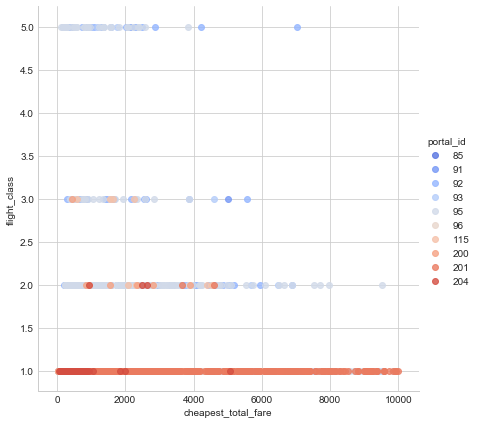

In [5]:
# variance of price / class per portal_id
sns.set_style('whitegrid')
sns.lmplot('cheapest_total_fare','flight_class',data=data, hue='portal_id',
           palette='coolwarm',size=6,aspect=1,fit_reg=False)

C:\Users\Maksym_Parats\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


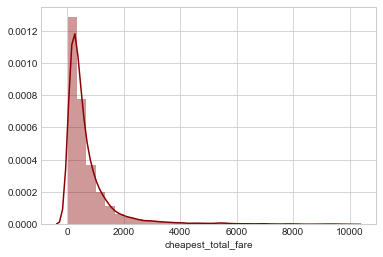

In [6]:
# price distribution
sns.distplot(data['cheapest_total_fare'].dropna(),kde=True,color='darkred',bins=30)

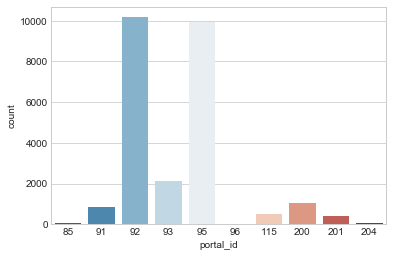

In [7]:
# number of searches per portal_id
sns.countplot(x='portal_id',data=data,palette='RdBu_r')

In [8]:
# grouping per portal_id due to count searches
data.groupby('portal_id').count()

,searched_date,origin,destination,departure_date,return_date,number_of_adults,number_of_children,number_of_seniors,flight_class,cheapest_total_fare,cheapest_engine,unique_airlines,country_code,region,city
portal_id,,,,,,,,,,,,,,,
85,68,68,68,68,36,68,68,68,68,68,68,68,68,68,68
91,837,837,837,837,496,837,837,837,837,837,837,837,837,837,837
92,10172,10172,10172,10172,6859,10172,10172,10172,10172,10172,10172,10172,10171,10172,10172
93,2145,2145,2145,2145,1299,2145,2145,2145,2145,2145,2145,2145,2145,2145,2145
95,9952,9952,9952,9952,5269,9952,9952,9952,9952,9952,9952,9952,9951,9952,9952
96,14,14,14,14,10,14,14,14,14,14,14,14,14,14,14
115,483,483,483,483,290,483,483,483,483,483,483,483,483,483,483
200,1040,1040,1040,1040,484,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040
201,417,417,417,417,247,417,417,417,417,417,417,417,417,417,417


In [9]:
# grouping per portal_id with average prices
data.groupby('portal_id')['cheapest_total_fare'].mean()

portal_id
85      604.197864
91      421.149262
92      691.549088
93      962.395392
95      637.518887
96     1779.720697
115     985.024693
200     455.617232
201    4345.439042
204     562.663820
Name: cheapest_total_fare, dtype: float64

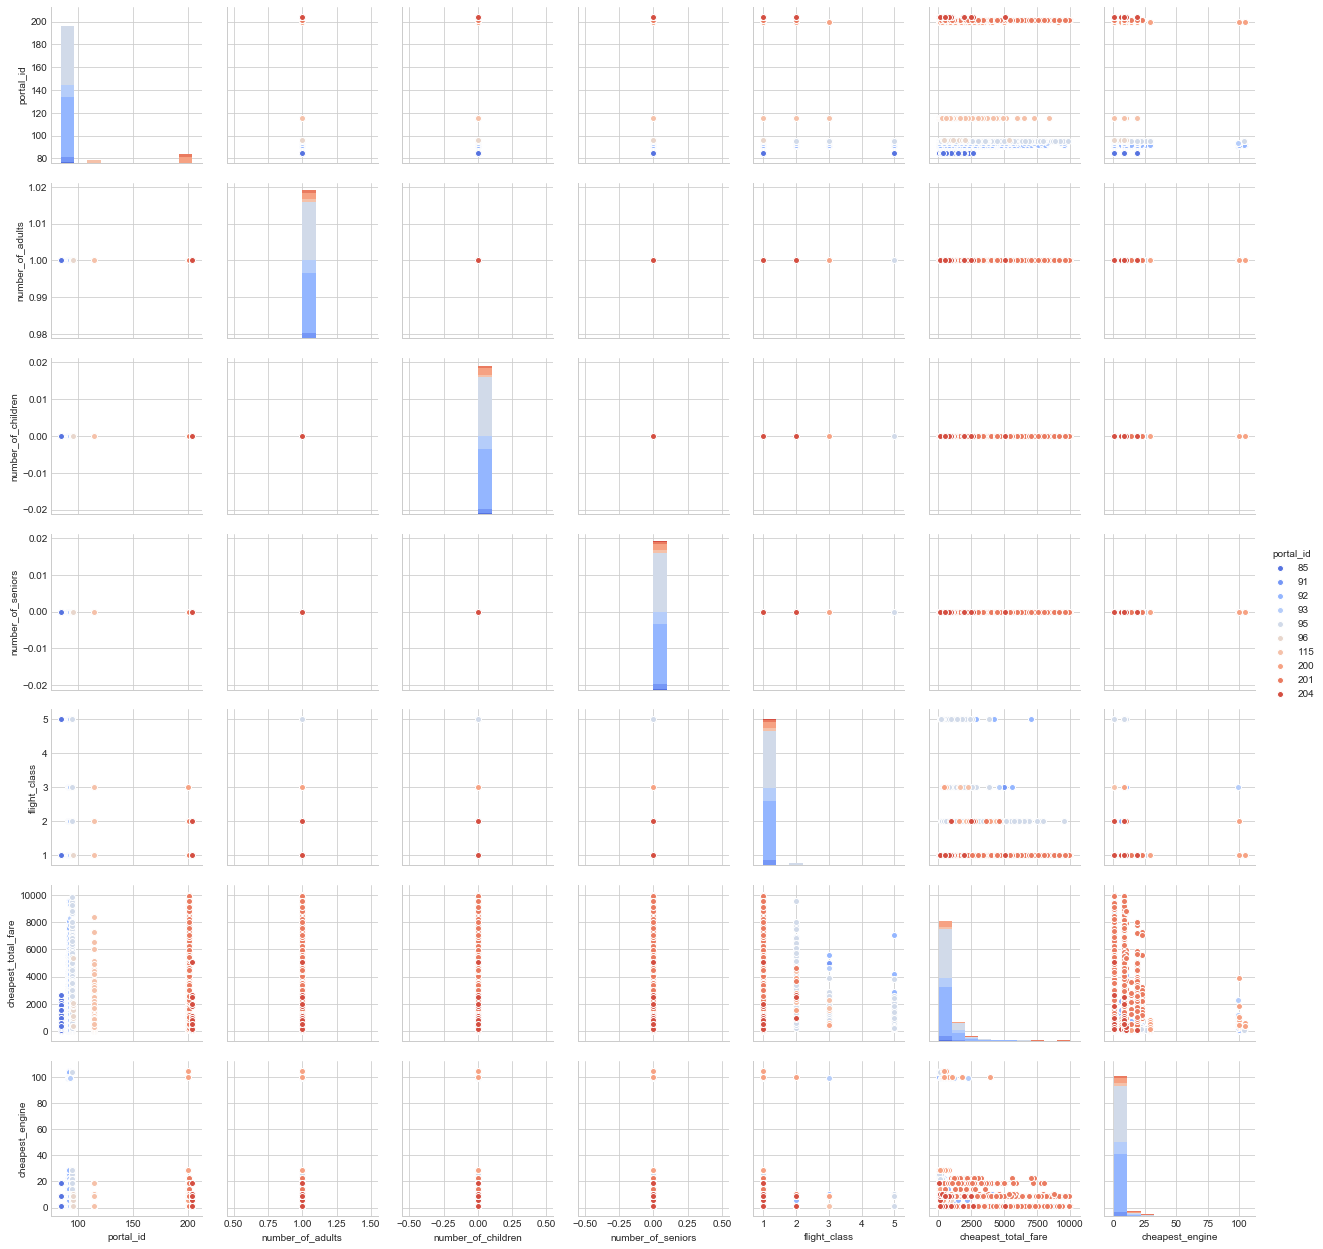

In [10]:
# general visualization with the hue indicated by the portal_id column
sns.pairplot(data,hue='portal_id',palette='coolwarm')

# Data preparation
We have not the marked labels via dataset so let's prepare data frame for unsupervised algorithm (KMeans clustering)

In [11]:
# label of origin, destination and portal_id into additional columns transforming non-numerical labels (as long as they are hashable and comparable) to numerical labels
le = preprocessing.LabelEncoder()
le.fit(data['origin'])
le.transform(data['origin'])
data['origin_trans'] = le.transform(data['origin'])

le.fit(data['destination'])
le.transform(data['destination'])
data['destination_trans'] = le.transform(data['destination'])

le.fit(data['portal_id'])
le.transform(data['portal_id'])
data['portal_id_trans'] = le.transform(data['portal_id'])

In [12]:
data['origin_trans'].head()

0    2165
1    2164
2    2163
3    2162
4    2161
Name: origin_trans, dtype: int64

In [13]:
data['destination_trans'].head()

0     182
1     303
2     952
3    1155
4     952
Name: destination_trans, dtype: int64

In [14]:
data['portal_id_trans'].head()

0    2
1    2
2    7
3    2
4    2
Name: portal_id_trans, dtype: int64

In [15]:
# create new data frame
df = data[['portal_id_trans', 'origin_trans', 'destination_trans', 'flight_class', 'cheapest_total_fare']]

In [16]:
df.head()

,portal_id_trans,origin_trans,destination_trans,flight_class,cheapest_total_fare
0,2,2165,182,1,271.799988
1,2,2164,303,1,106.809998
2,7,2163,952,1,523.660000
3,2,2162,1155,1,372.899994
4,2,2161,952,1,546.059998


In [17]:
# first of all we should define the optimal numbers of clusters
# 1. The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. 
# The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.
matrix = df.as_matrix()
for n_clusters in range(2,25):
    kmeans = KMeans(n_clusters = n_clusters)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print('For n_clusters =', n_clusters, 'the average silhoette_score is :', silhouette_avg)

C:\Users\Maksym_Parats\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


For n_clusters = 2 the average silhoette_score is : 0.6782109599945793
For n_clusters = 3 the average silhoette_score is : 0.3272052207494119
For n_clusters = 4 the average silhoette_score is : 0.3463712409430942
For n_clusters = 5 the average silhoette_score is : 0.3106986360061494
For n_clusters = 6 the average silhoette_score is : 0.28896394610296255
For n_clusters = 7 the average silhoette_score is : 0.293197014981463
For n_clusters = 8 the average silhoette_score is : 0.30004176884325845
For n_clusters = 9 the average silhoette_score is : 0.30005457437800515
For n_clusters = 10 the average silhoette_score is : 0.300984888393984
For n_clusters = 11 the average silhoette_score is : 0.2833581423367359
For n_clusters = 12 the average silhoette_score is : 0.2859074616932612
For n_clusters = 13 the average silhoette_score is : 0.2775355939049041
For n_clusters = 14 the average silhoette_score is : 0.2782992240714318
For n_clusters = 15 the average silhoette_score is : 0.2830065173371945

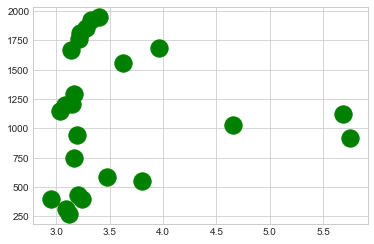

In [22]:
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], s = 300, c = 'green', label = 'Centroids')

Text(0.5,1,'Selecting k with Elbow method')

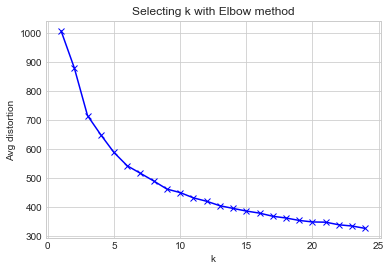

In [19]:
# 2. Elbow method. The idea of the elbow method is to run k-means clustering on the dataset for a range of values of k (say, k from 1 to 10 in the examples above), and for each value of k calculate the sum of squared errors (SSE).
clusters = range(1,25)
meanDistortions = []
for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(df)
    prediction = model.predict(df)
    meanDistortions.append(sum(np.min(distance.cdist(df, model.cluster_centers_,'euclidean'), axis = 1)) /
    data.shape[0])
    
plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Avg distortion')
plt.title('Selecting k with Elbow method')

Silhouette_score shows the best clusters are 2 and 4
Elbow_method is too smooth and we just approximately can select 5 and 7 clusters numbers

In [23]:
# n_clusters=2
kmeans = KMeans(n_clusters=2)
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [24]:
kmeans.cluster_centers_

array([[4.35795455e+00, 1.11036445e+03, 8.08525162e+02, 1.11850649e+00,
        4.30528985e+03],
       [3.18286883e+00, 1.10001101e+03, 7.52209154e+02, 1.02173732e+00,
        5.57406480e+02]])

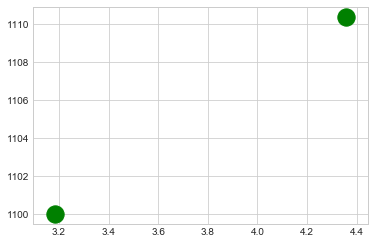

In [26]:
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], s = 300, c = 'green', label = 'Centroids')

In [27]:
# n_clusters=4
kmeans = KMeans(n_clusters=4)
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

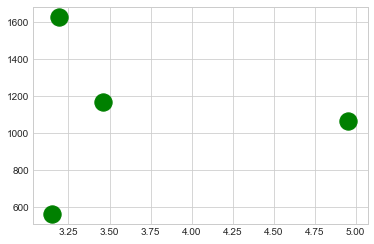

In [28]:
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], s = 300, c = 'green', label = 'Centroids')

In [29]:
# n_clusters=5
kmeans = KMeans(n_clusters=5)
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

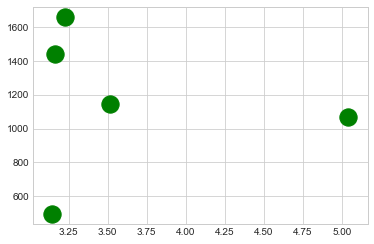

In [30]:
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], s = 300, c = 'green', label = 'Centroids')

In [31]:
# n_clusters=7
kmeans = KMeans(n_clusters=7)
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

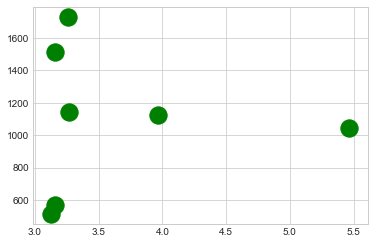

In [32]:
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], s = 300, c = 'green', label = 'Centroids')

## Assume that we are going to detect by features wich portal_id is used by user

We can use bulk of supervised classification models. Let's try it.

In [33]:
#features and labels extraction from scaled data
features = df.drop('portal_id_trans', axis = 1)
labels = data['portal_id']

In [34]:
features.head()

,origin_trans,destination_trans,flight_class,cheapest_total_fare
0,2165,182,1,271.799988
1,2164,303,1,106.809998
2,2163,952,1,523.660000
3,2162,1155,1,372.899994
4,2161,952,1,546.059998


In [35]:
labels.head()

0     92
1     92
2    200
3     92
4     92
Name: portal_id, dtype: int64

In [36]:
print (len(features))
print (len(labels))

25200
25200


In [37]:
# cross-validation
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)
print ('The length of training data is {}'.format(len(X_train)))
print ('The length of testing data is {}'.format(len(X_test)))

The length of training data is 16884
The length of testing data is 8316


In [38]:
# scoring function printing model's accuracy
def scoring(X,pred):
    result = 'Accuracy score is {0:.2f}%'.format(accuracy_score(X, pred)*100) 
    return result

In [39]:
#NAIVE
t0 = time()
clf = GaussianNB()
clf.fit(X_train,y_train)
prediction = clf.predict(X_test)
print ("time on training and prediction:", round(time()-t0, 3), "s")  
print (scoring(prediction, y_test))

time on training and prediction: 0.001 s
Accuracy score is 43.10%


In [56]:
#SVM

t0 = time()
clf = SVC()
clf.fit(X_train,y_train)
prediction = clf.predict(X_test)
print ("time on training and prediction:", round(time()-t0, 3), "s")  
print (scoring(prediction, y_test))

# We can fit parameters using GridSearchCV(estimator=svm.SVC(), param_grid=parameters, n_jobs=-1)
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100, 1000, 10000], 'gamma': [0.1, 0.01, 0.001, 0.0001, 0.00001]}

time on training and prediction: 85.539 s
Accuracy score is 43.96%


In [44]:
#decision tree
t0 = time()
clf = tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)
prediction = clf.predict(X_test)
print (scoring(prediction, y_test))
print ("time on training and prediction:", round(time()-t0, 3), "s")  

Accuracy score is 45.98%
time on training and prediction: 0.099 s


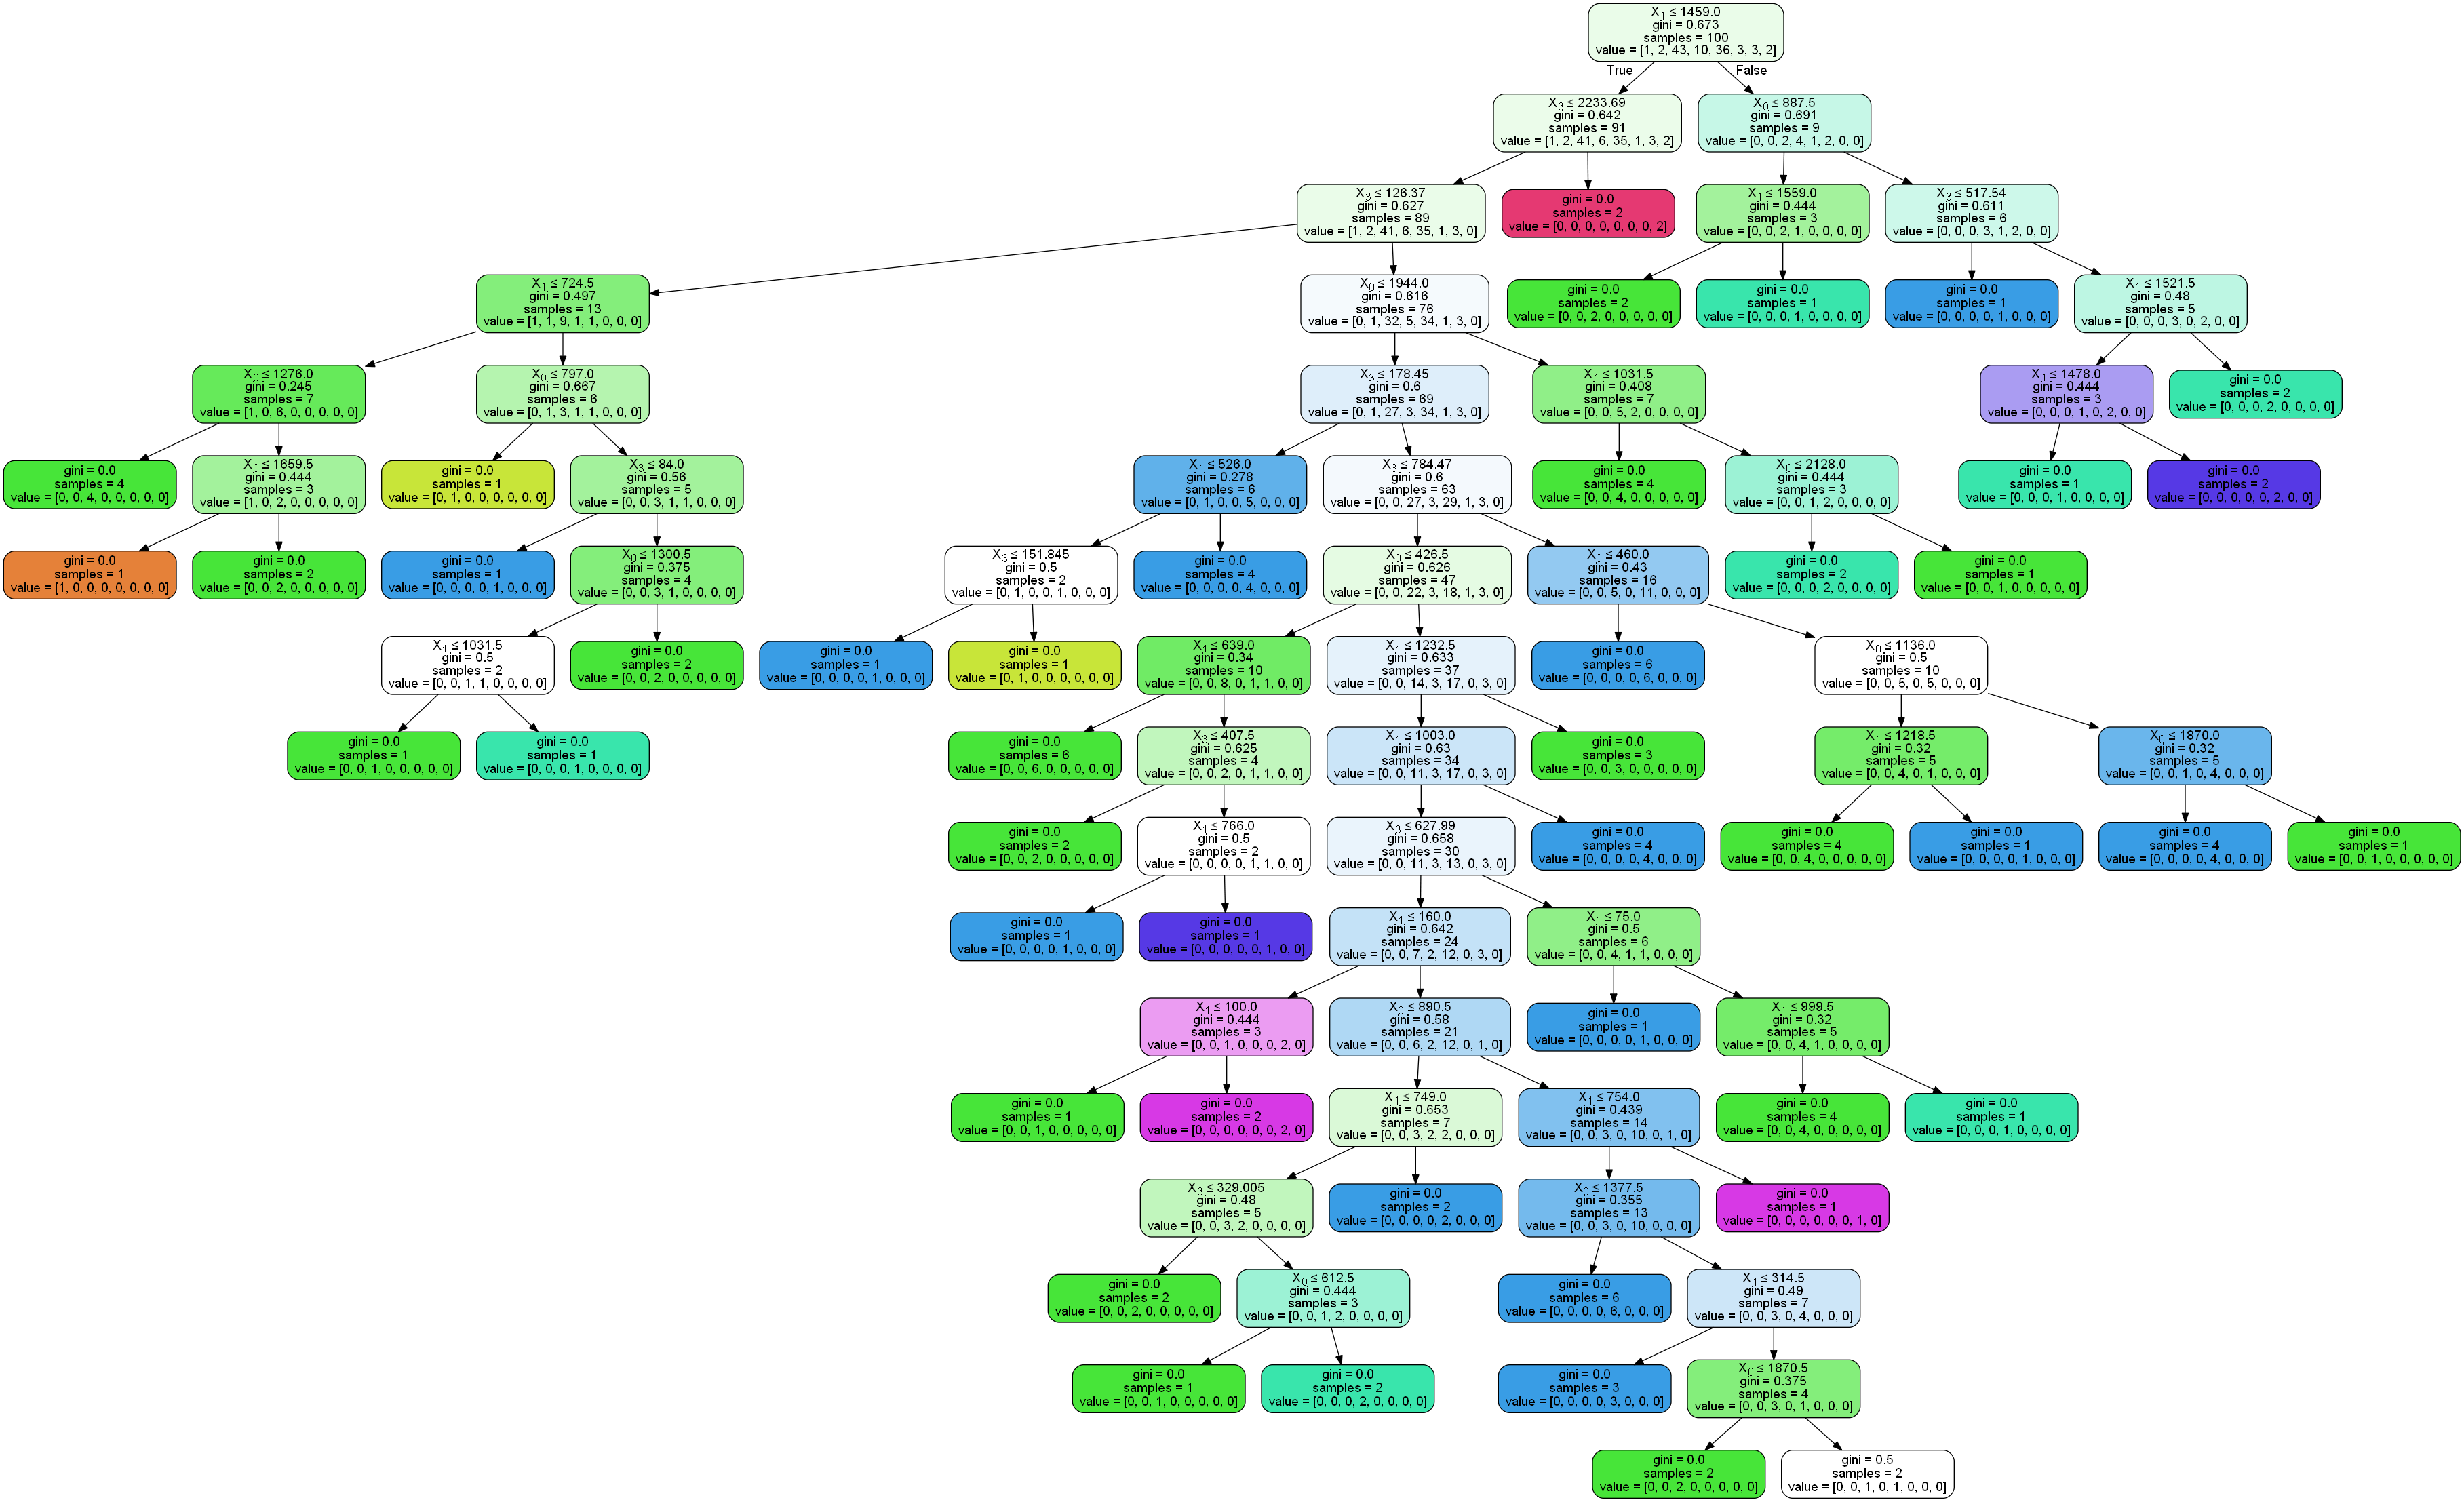

In [47]:
#decision tree - graphing (use new clf with less train and test data)
# 100 samples
clf = tree.DecisionTreeClassifier()
clf.fit(X_train[:100],y_train[:100])
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [48]:
#XGBoost

t0 = time()
model = XGBClassifier()
model.fit(X_train, y_train)
print (model)
pred = model.predict(X_test)
print ("time on training and prediction:", round(time()-t0, 3), "s")
print (scoring(pred, y_test))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
time on training and prediction: 3.62 s
Accuracy score is 51.64%


C:\Users\Maksym_Parats\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [51]:
#XGBoost-best params

warnings.simplefilter('ignore', DeprecationWarning)
# Create the parameter grid: gbm_param_grid
gbm_param_grid = {
    'n_estimators': range(8, 20),
    'max_depth': range(6, 10),
    'learning_rate': [.4, .45, .5, .55, .6],
    'colsample_bytree': [.6, .7, .8, .9, 1]
}

# Instantiate the regressor: gbm
gbm = XGBClassifier(n_estimators=10)

# Perform random search: grid_mse
xgb_random = RandomizedSearchCV(param_distributions=gbm_param_grid,
                                    estimator = gbm, scoring = "accuracy",
                                    verbose = 1, n_iter = 50, cv = 4)

# Fit randomized_mse to the data
xgb_random.fit(X_train, y_train)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", xgb_random.best_params_)
print("Best accuracy found: ", xgb_random.best_score_)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.4min finished


Best parameters found:  {'n_estimators': 19, 'max_depth': 7, 'learning_rate': 0.5, 'colsample_bytree': 0.6}
Best accuracy found:  0.5310352996920161


## CATBOOST

In [2]:
data_cat = pd.read_csv('sample_searches.csv')

In [3]:
data_cat.head()

,portal_id,searched_date,origin,destination,departure_date,return_date,number_of_adults,number_of_children,number_of_seniors,flight_class,cheapest_total_fare,cheapest_engine,unique_airlines,country_code,region,city
0,92,2017-01-06,ZYR,BUD,2017-03-23,2017-03-25,1,0,0,1,271.799988,9,AF*KL KL*AF AF*SN KL*SN AF*LH KL*LH AF*AZ,-,-,-
1,92,2017-01-06,ZYL,DAC,2017-01-25,NaN,1,0,0,1,106.809998,9,BG,US,NEW JERSEY,WOODBRIDGE
2,200,2017-01-06,ZWS,NYC,2017-01-22,2017-05-30,1,0,0,1,523.660000,9,LH AB,-,-,-
3,92,2017-01-06,ZWI,SAV,2017-01-10,2017-01-19,1,0,0,1,372.899994,1,UA UA*AA,-,-,-
4,92,2017-01-06,ZWE,NYC,2017-03-26,2017-04-04,1,0,0,1,546.059998,1,KL*AF,NL,ZUID-HOLLAND,DORDRECHT


In [4]:
null_value_stats = data_cat.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

return_date     10181
country_code        2
dtype: int64

In [5]:
# Now let's separate features and label variable:
X = data_cat[['origin', 'destination', 'flight_class', 'cheapest_total_fare']]
y = data_cat.portal_id

In [6]:
print(X.dtypes)

origin                  object
destination             object
flight_class             int64
cheapest_total_fare    float64
dtype: object


In [7]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]
categorical_features_indices

array([0, 1, 2], dtype=int64)

In [8]:
from sklearn.model_selection import train_test_split

X_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

C:\Users\Maksym_Parats\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
len(y_test)

6300

In [10]:
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent',
    loss_function='MultiClass'
)

In [11]:
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(x_test, y_test),
    #logging_level='Verbose',  # you can uncomment this for text output
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [13]:
# Model Cross-Validation
cv_params = model.get_params()
cv_params.update({
    'loss_function': 'MultiClass'
})
cv_data = cv(
    Pool(X, y, cat_features=categorical_features_indices),
    cv_params,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [14]:
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-Accuracy-mean']),
    cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
    np.argmax(cv_data['test-Accuracy-mean'])
))

Best validation accuracy score: 0.60±0.00 on step 967


C:\Users\Maksym_Parats\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


In [15]:
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

Precise validation accuracy score: 0.6046031746031746


The best model is Catboost (accuracy 60,4%)

## THANKS!